# Using **previous_application.csv**

# 라이브러리 및 데이터 로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os, gc, sys
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 30)

### application 데이터 로드

In [3]:
path = '/content/drive/MyDrive/kaggle/home_credit_default_risk'
app_train = pd.read_csv(os.path.join(path, 'application_train.csv'))
app_test = pd.read_csv(os.path.join(path, 'application_test.csv'))

In [4]:
def get_apps():
  path = '/content/drive/MyDrive/kaggle/home_credit_default_risk'
  app_train = pd.read_csv(os.path.join(path, 'application_train.csv'))
  app_test = pd.read_csv(os.path.join(path, 'application_test.csv'))

  apps = pd.concat([app_train, app_test])

  return apps

apps = get_apps()

In [5]:
apps.shape

(356255, 122)

### app_baseline에서 진행한 feature engineering 함수화

In [6]:
def get_apps_feature_engineering(apps):

  # EXT_SOURCE_1,2,3 feature 가공
  apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
  apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
  apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())

  # AMT_CREDIT 비율로 feature 가공
  apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
  apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
  # AMT_INCOME_TOTAL 비율로 feature 가공
  apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
  apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
  apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
  apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
  # DAYS_BIRTH, DAYS_EMPLOYED 비율로 feature 가공
  apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
  apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
  apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
  apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
  apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
  return apps

### previous_application 데이터 로드

In [7]:
path = '/content/drive/MyDrive/kaggle/home_credit_default_risk'
prev = pd.read_csv(os.path.join(path, 'previous_application.csv'))

print(apps.shape, prev.shape)

(356255, 122) (1670214, 37)


In [8]:
prev.head(3)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0


### apps와 previous_application 데이터 outer 조인

In [9]:
prev_app_outer = prev.merge(apps['SK_ID_CURR'], on='SK_ID_CURR', how='outer', indicator=True)
prev_app_outer.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,_merge
0,2030495.0,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15.0,Y,1.0,0.000000,0.182832,0.867336,XAP,Approved,-73.0,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35.0,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,both
1,1696966.0,271877,Consumer loans,68258.655,1800000.0,1754721.0,180000.0,1800000.0,SATURDAY,18.0,Y,1.0,0.101325,NaN,NaN,XAP,Refused,-472.0,Cash through the bank,SCO,NaN,Repeater,Clothing and Accessories,POS,XNA,Regional / Local,55.0,Furniture,36.0,low_normal,POS industry with interest,NaN,NaN,NaN,NaN,NaN,NaN,both
2,2154916.0,271877,Consumer loans,12417.390,108400.5,119848.5,0.0,108400.5,SUNDAY,14.0,Y,1.0,0.000000,NaN,NaN,XAP,Approved,-548.0,Cash through the bank,XAP,NaN,New,Furniture,POS,XNA,Stone,196.0,Furniture,12.0,middle,POS industry with interest,365243.0,-512.0,-182.0,-392.0,-387.0,0.0,both
3,2802425.0,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11.0,Y,1.0,NaN,NaN,NaN,XNA,Approved,-164.0,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1.0,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,both
4,1536272.0,108129,Cash loans,21709.125,450000.0,512370.0,NaN,450000.0,WEDNESDAY,9.0,Y,1.0,NaN,NaN,NaN,XNA,Approved,-515.0,XNA,XAP,NaN,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),6.0,XNA,36.0,low_normal,Cash X-Sell: low,365243.0,-485.0,565.0,-155.0,-147.0,1.0,both


- indicator= True 로 누락되는 부분 확인

In [10]:
prev_app_outer['_merge'].value_counts()

both          1670214
right_only      17398
left_only           0
Name: _merge, dtype: int64

### ***previous 컬럼 설명***



|Table|컬럼명|컬럼 대분류|컬럼 중분류|컬럼 설명|
|------|--------|----|--------|-----------------|
|previous_application.csv|SK_ID_PREV |대출|고유ID|과거 대출 고유 ID|
|previous_application.csv|SK_ID_CURR|대출|고유ID|현재 대출 고유 ID|
|previous_application.csv|NAME_CONTRACT_TYPE|대출|대출 유형|대출 유형|
|previous_application.csv|AMT_ANNUITY|대출|대출 금액|월 대출 지급액|
|previous_application.csv|AMT_APPLICATION|대출|대출 금액|대출 신청 금액|
|previous_application.csv|AMT_CREDIT|대출|대출 금액|대출금액(허가)|
|previous_application.csv|AMT_DOWN_PAYMENT|대출|대출 금액|대출 시 납부한 선금액|
|previous_application.csv|AMT_GOODS_PRICE|대출|대출 금액|소비자 대출상품액|
|previous_application.csv|WEEKDAY_APPR_PROCESS_START|고객|행동|대출 신청 시작 요일|
|previous_application.csv|HOUR_APPR_PROCESS_START|고객|행동|대출 신청 시작 시간대|
|previous_application.csv|FLAG_LAST_APPL_PER_CONTRACT|고객|행동|이전 계약의 마지막 대출 신청 여부|
|previous_application.csv|NFLAG_LAST_APPL_IN_DAY|고객|행동|하루중 마지막 대출 신청 여부(하루에 여러 번 대출 신청했을 경우)|
|previous_application.csv|NFLAG_MICRO_CASH|대출|대출 유형|소액 대출 여부|
|previous_application.csv|RATE_DOWN_PAYMENT|대출|대출 금액|선금 비율(정규화됨)|
|previous_application.csv|RATE_INTEREST_PRIMARY|대출|대출 금액|이자율|
|previous_application.csv|RATE_INTEREST_PRIVILEGED|대출|대출 금액|이자율|
|previous_application.csv|NAME_CASH_LOAN_PURPOSE|대출|대출 유형|현금 대출 목적|
|previous_application.csv|NAME_CONTRACT_STATUS|대출|대출 상태|대출 상태(허가, 취소)|
|previous_application.csv|DAYS_DECISION|대출|대출 상태|과거 신청 대비 현재 신청 결정 기간|
|previous_application.csv|NAME_PAYMENT_TYPE|대출|대출 유형|과거 대출 신청의 납부 방법|
|previous_application.csv|CODE_REJECT_REASON|대출|대출 상태|과거 신청 거절 사유|
|previous_application.csv|NAME_TYPE_SUITE|고객|행동(추천)|동행 고객|
|previous_application.csv|NAME_CLIENT_TYPE|고객|행동|신규 고객 또는 기존 대출 고객 여부|
|previous_application.csv|NAME_GOODS_CATEGORY|대출|대출 유형|대출 상품 중분류 유형|
|previous_application.csv|NAME_PORTFOLIO|대출|대출 유형|현금대출/POS/CAR 대출 유형|
|previous_application.csv|NAME_PRODUCT_TYPE|채널|판매 유형|고객이 찾아온 대출인가, 영업 대출인가|
|previous_application.csv|CHANNEL_TYPE|채널|채널 유형|채널 유형|
|previous_application.csv|SELLERPLACE_AREA|채널|채널 유형|판매자 판매 지역|
|previous_application.csv|NAME_SELLER_INDUSTRY|채널|채널 유형|판매자 Industry|
|previous_application.csv|CNT_PAYMENT|대출|대출 금액|이전 대출 신청의 대출금액 관련 Term|
|previous_application.csv|NAME_YIELD_GROUP|대출|대출 금액|집단 금리 적용 유형|
|previous_application.csv|PRODUCT_COMBINATION|대출|대출 유형|이전 대출 결합 상품|
|previous_application.csv|DAYS_FIRST_DRAWING|대출|상태|신청날짜부터 최초 대출 지급까지의 일자|
|previous_application.csv|DAYS_FIRST_DUE|대출|상태|신청날짜부터 마감일까지의 일자|
|previous_application.csv|DAYS_LAST_DUE_1ST_VERSION|대출|상태|신청날짜부터 첫 만기일까지의 일자|
|previous_application.csv|DAYS_LAST_DUE|대출|상태|신청날짜부터 마지막 만기일까지의 일자|
|previous_application.csv|DAYS_TERMINATION|대출|상태|현 대출 신청일자 대비 대출 예상 종료 일자|
|previous_application.csv|NFLAG_INSURED_ON_APPROVAL|대출|상태|대출 신청 시 보험가입 요청여부|

- previous 데이터 컬럼과 Null값 확인

In [11]:
prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

# EDA

#### SK_ID_CURR 당 평균 SK_ID_PREV 건수 

In [12]:
prev.groupby('SK_ID_CURR')['SK_ID_PREV'].count().mean()

4.928964135313716

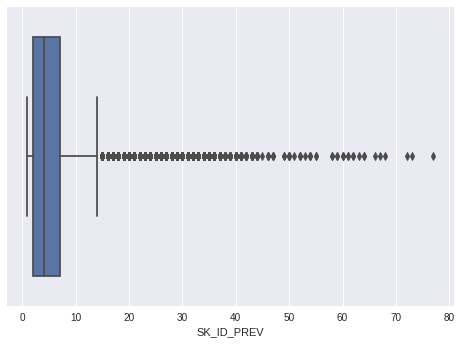

In [13]:
sns.boxplot(prev.groupby('SK_ID_CURR')['SK_ID_PREV'].count())

### TARGET 값에 따른 연속형 feature들의 Histogram

In [14]:
# TARGET 값을 가져오기위해 application 데이터셋과 조인
app_prev = prev.merge(app_train[['SK_ID_CURR','TARGET']], on='SK_ID_CURR', how='left')
app_prev.shape

(1670214, 38)

In [15]:
def show_hist_by_target(df, columns):
  cond_1 = (df['TARGET'] == 1)
  cond_0 = (df['TARGET'] == 0)

  for column in columns:
    fig, axes = plt.subplots(1, 2, figsize=(12,4), squeeze=False)
    sns.violinplot(x='TARGET', y=column, data=df, ax=axes[0][0])

    sns.distplot(df[cond_0][column], ax=axes[0][1], label='0', color='blue')
    sns.distplot(df[cond_1][column], ax= axes[0][1], label='1', color='red')

In [16]:
num_columns = app_prev.dtypes[app_prev.dtypes != 'object'].index.tolist()
num_columns = [column for column in num_columns if column not in ['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']]
print(num_columns)

['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']


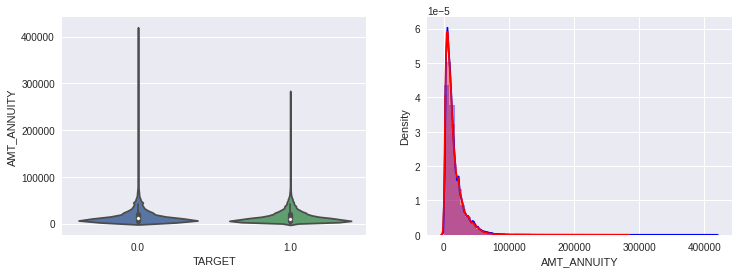

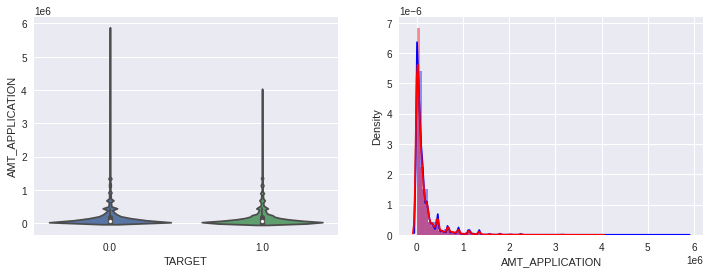

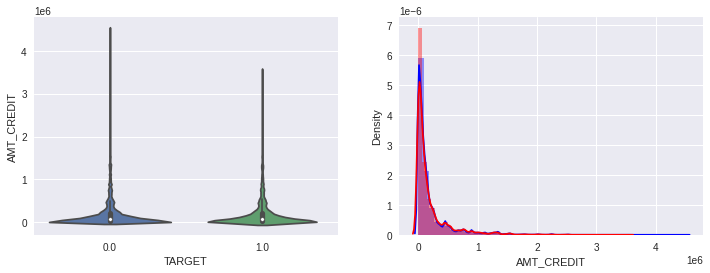

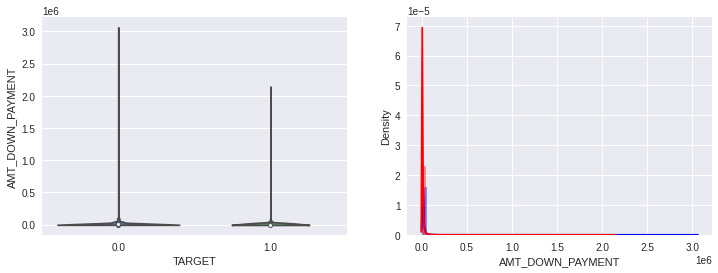

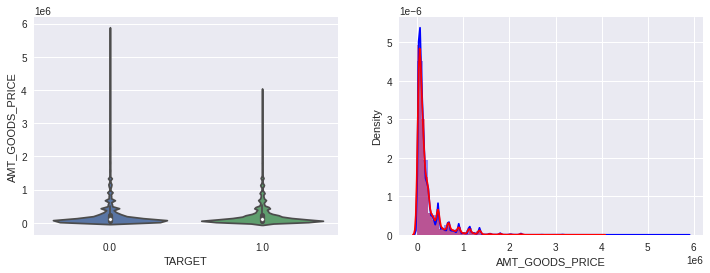

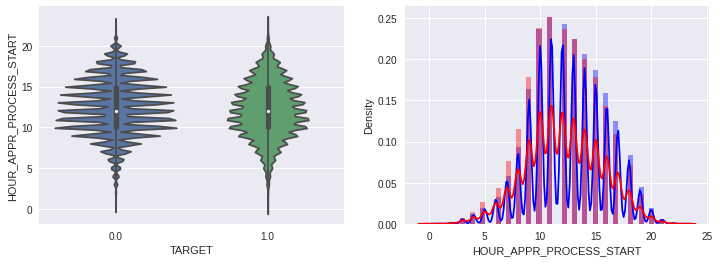

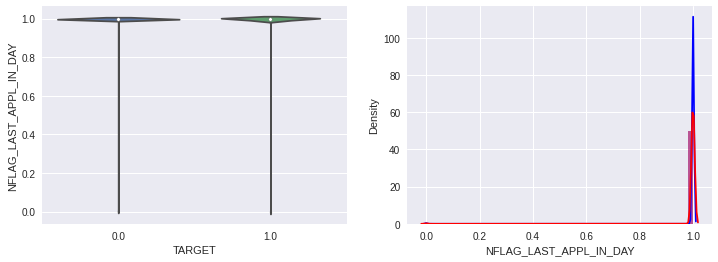

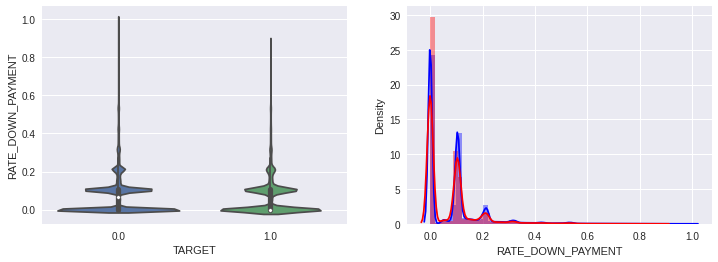

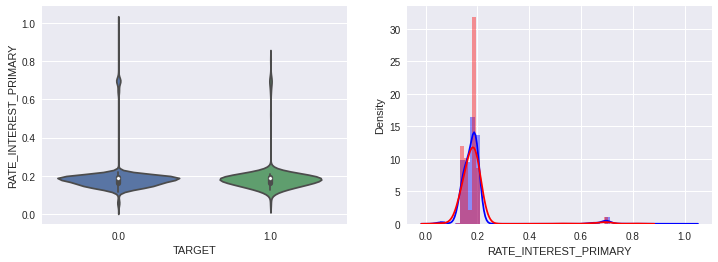

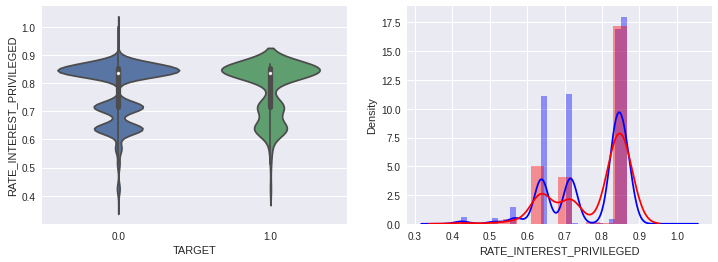

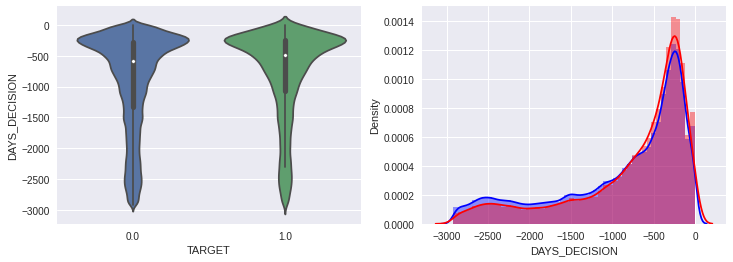

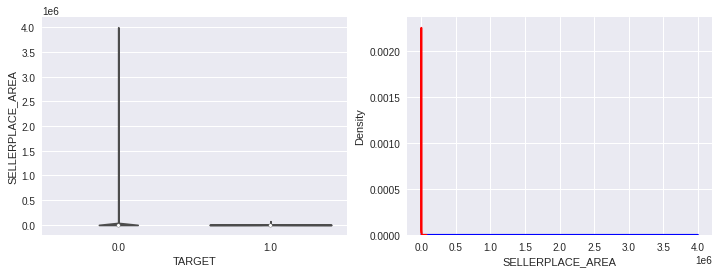

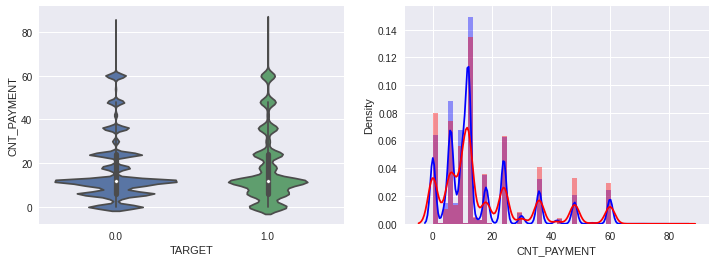

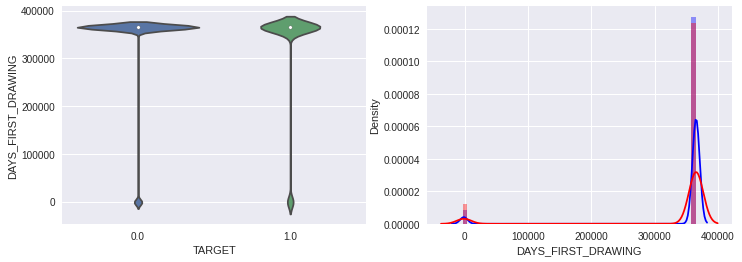

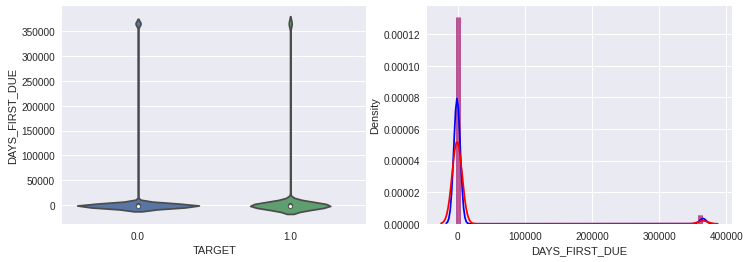

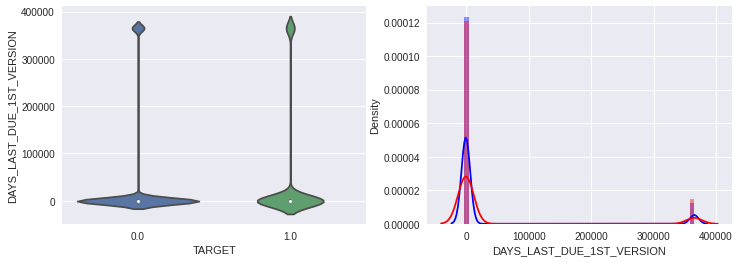

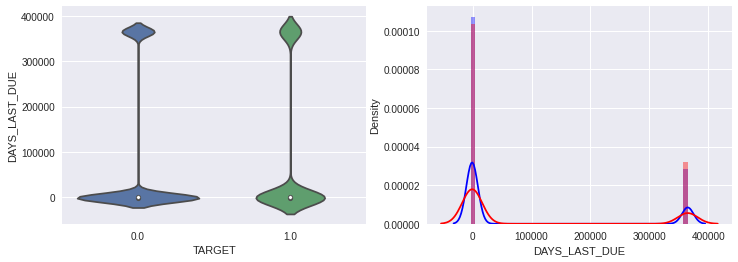

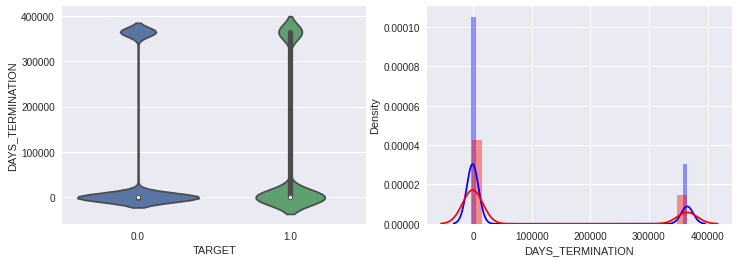

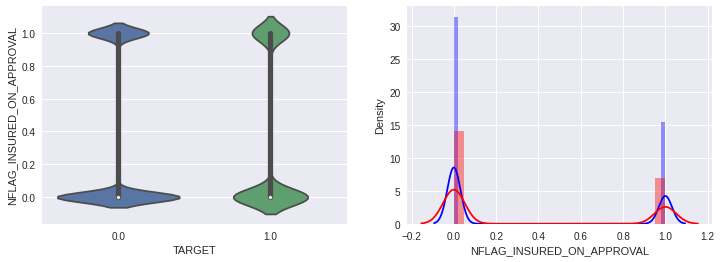

In [17]:
show_hist_by_target(app_prev, num_columns)

DAYS_ feautre들 365243 NULL값이 많음

### TARGET 값에 따른 Category feature들의 Histogram

In [18]:
object_columns = app_prev.dtypes[app_prev.dtypes == 'object'].index.tolist()
object_columns

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

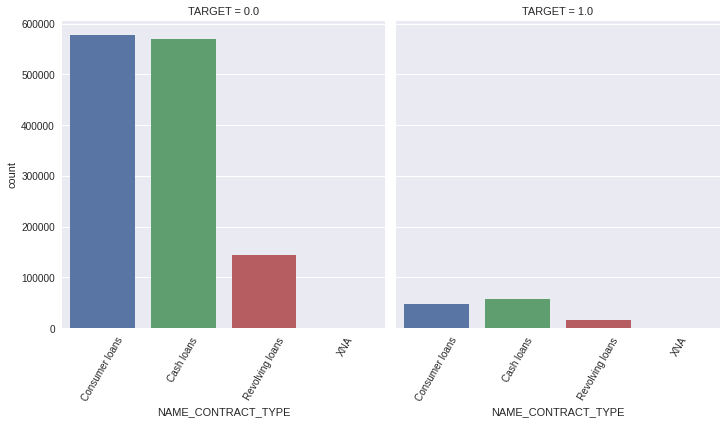

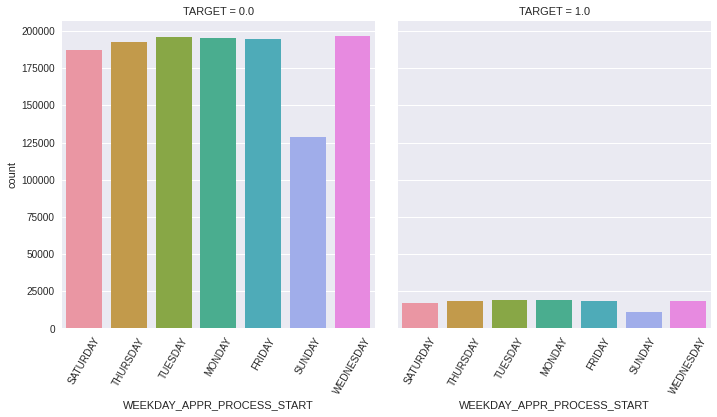

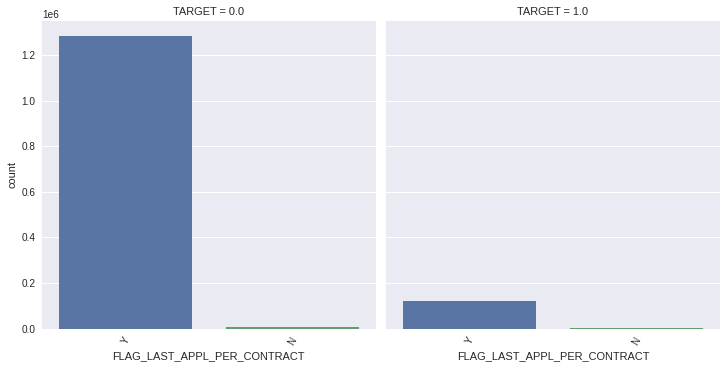

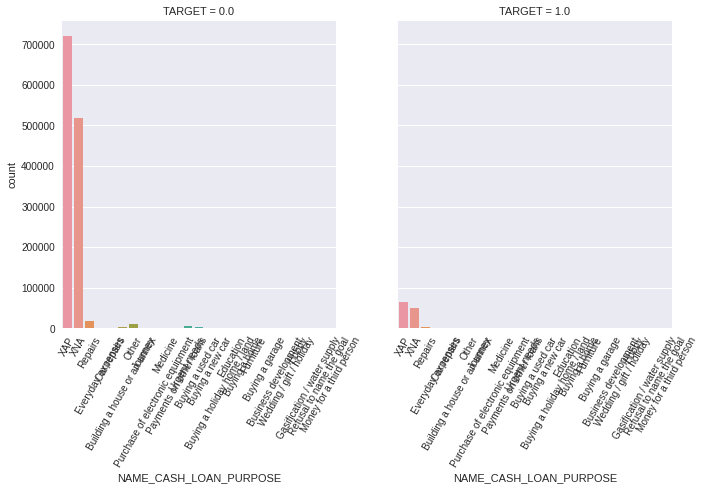

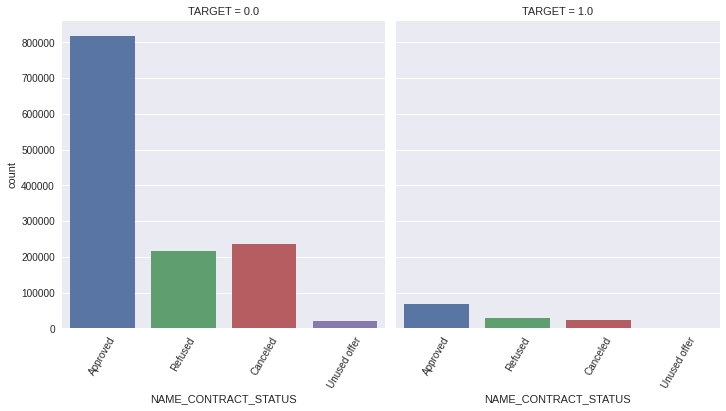

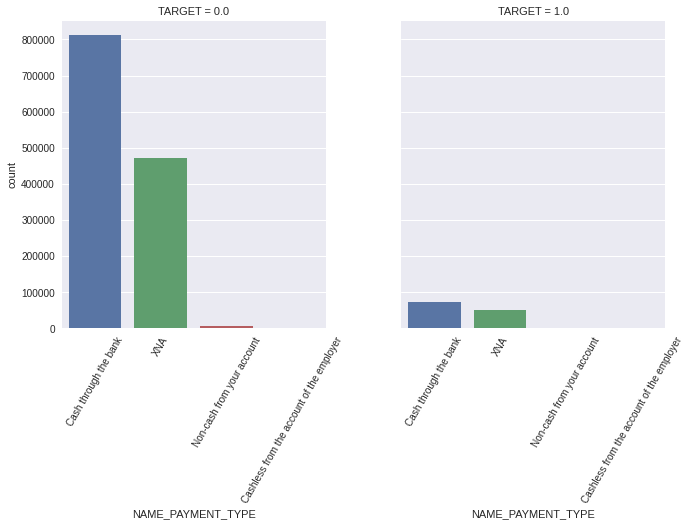

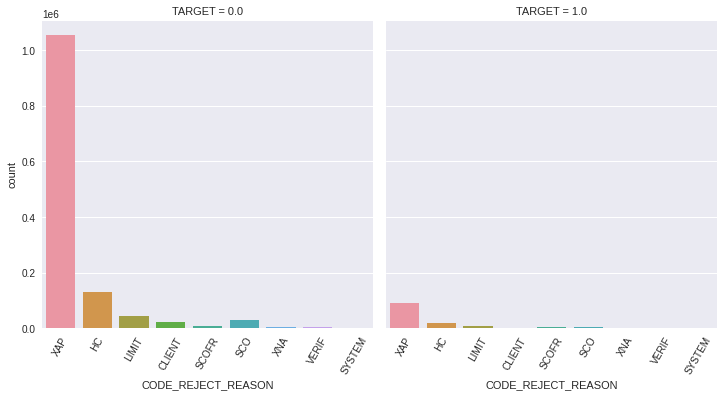

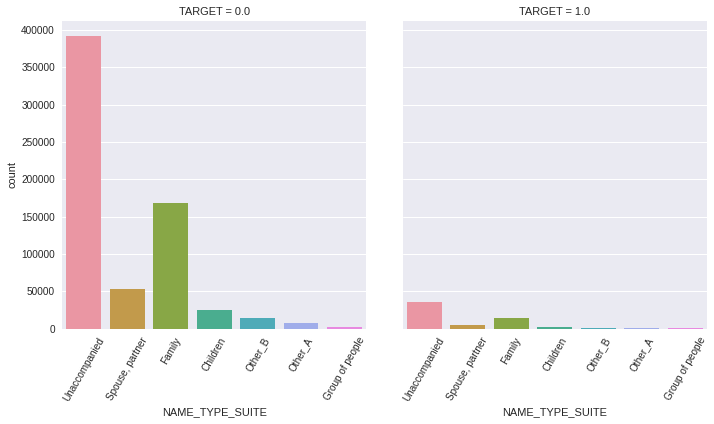

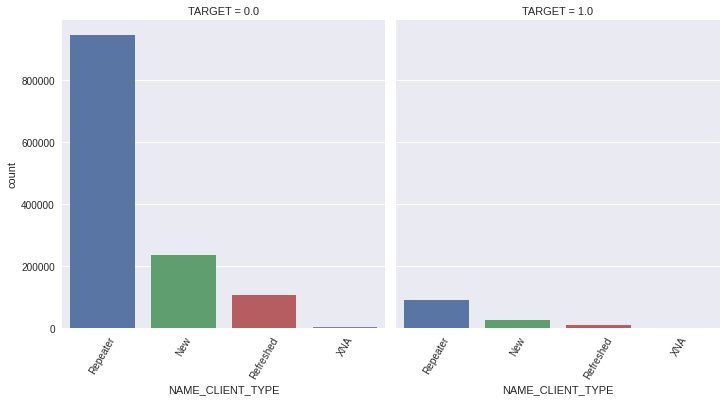

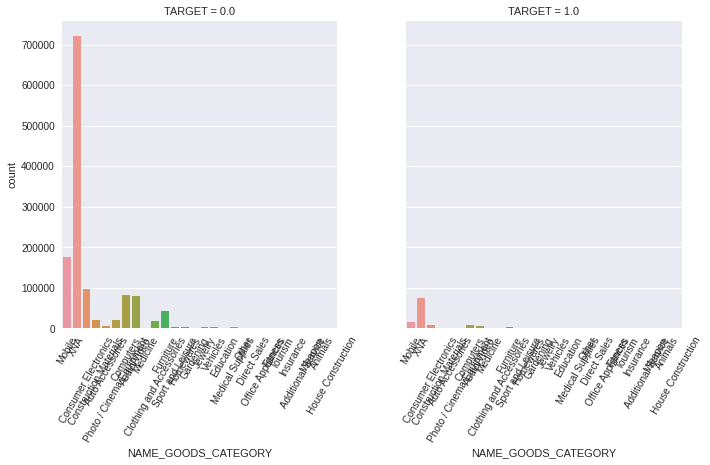

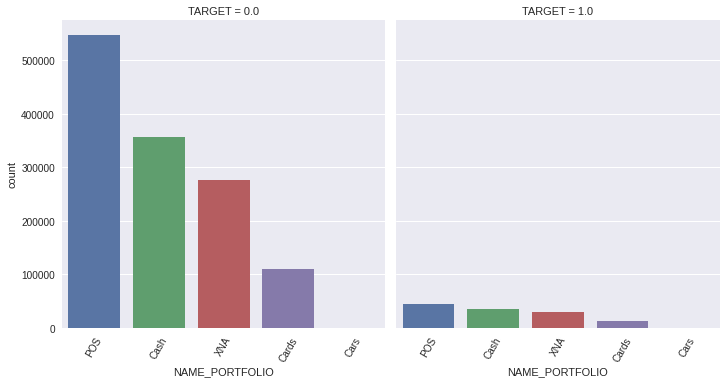

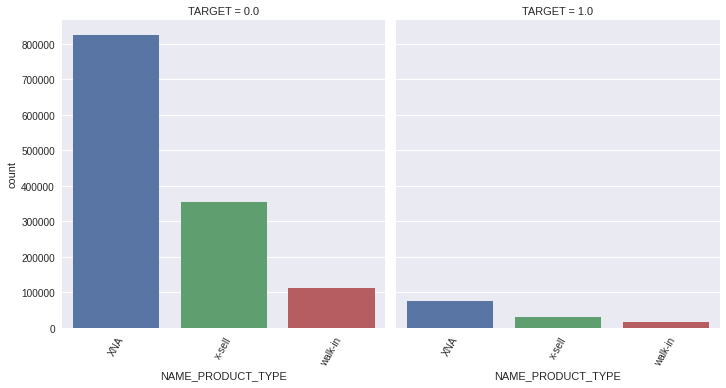

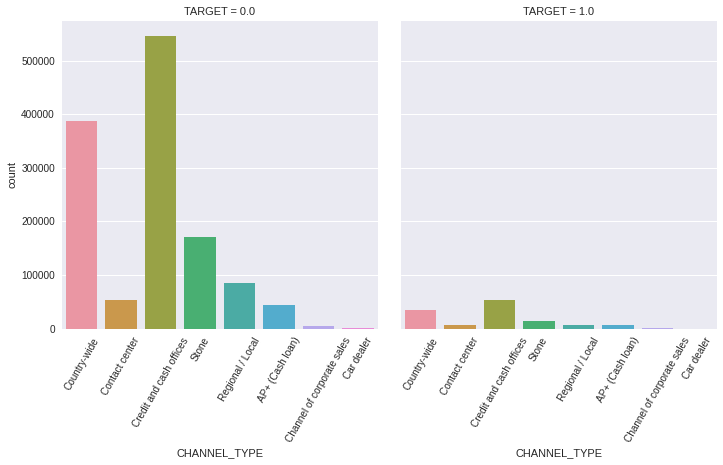

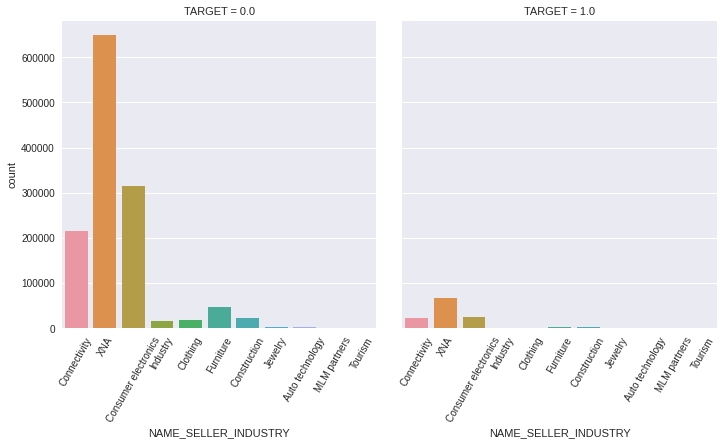

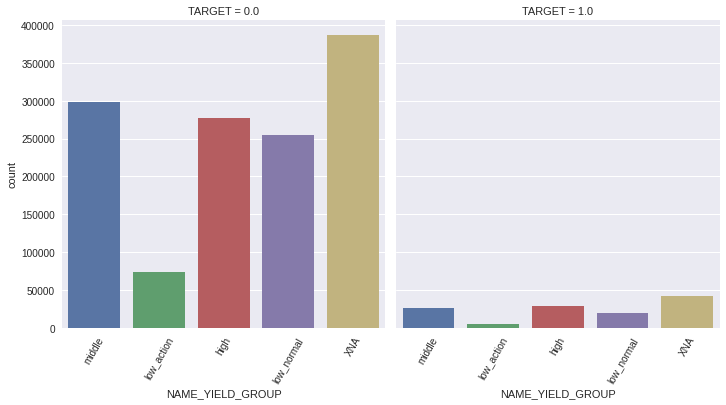

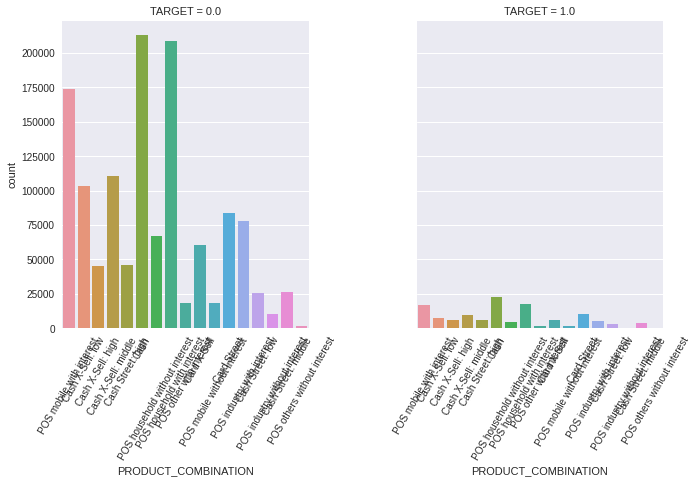

In [19]:
def show_category_by_target(df, columns):
  for column in columns:
    chart = sns.catplot(x=column, col='TARGET', data=df, kind='count')
    chart.set_xticklabels(rotation=60)
  
show_category_by_target(app_prev, object_columns)

# Feature Engineering

#### SK_ID_CURR 별 AMT_features 

In [29]:
agg_dict = {
    'SK_ID_CURR':['count'],
    'AMT_CREDIT':['mean', 'max', 'sum'],
    'AMT_ANNUITY':['mean', 'max', 'sum'], 
    'AMT_APPLICATION':['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE':['mean', 'max', 'sum']
}

prev_group = prev.groupby('SK_ID_CURR')
prev_amt_agg = prev_group.agg(agg_dict)
prev_amt_agg.head()

SK_ID_CURR AMT_CREDIT                       AMT_ANNUITY             \
                count       mean        max        sum        mean        max   
SK_ID_CURR                                                                      
100001              1   23787.00    23787.0    23787.0    3951.000   3951.000   
100002              1  179055.00   179055.0   179055.0    9251.775   9251.775   
100003              3  484191.00  1035882.0  1452573.0   56553.990  98356.995   
100004              1   20106.00    20106.0    20106.0    5357.250   5357.250   
100005              2   20076.75    40153.5    40153.5    4813.200   4813.200   

                       AMT_APPLICATION                      AMT_DOWN_PAYMENT  \
                   sum            mean       max        sum             mean   
SK_ID_CURR                                                                     
100001        3951.000        24835.50   24835.5    24835.5           2520.0   
100002        9251.775       179055.00  179055.0   179055.0              0.0   
100003      169661.970       435436.50  900000.0  1306309.5           3442.5   
100004        5357.250        24282.00   24282.0    24282.0           4860.0   
100005        4813.200        22308.75   44617.5    44617.5           4464.0   

                           AMT_GOODS_PRICE                       
               max     sum            mean       max        sum  
SK_ID_CURR                                                       
100001      2520.0  2520.0         24835.5   24835.5    24835.5  
100002         0.0     0.0        179055.0  179055.0   179055.0  
100003      6885.0  6885.0        435436.5  900000.0  1306309.5  
100004      4860.0  4860.0         24282.0   24282.0    24282.0  
100005      4464.0  4464.0         44617.5   44617.5    44617.5

In [30]:
prev_amt_agg.columns

MultiIndex([(      'SK_ID_CURR', 'count'),
            (      'AMT_CREDIT',  'mean'),
            (      'AMT_CREDIT',   'max'),
            (      'AMT_CREDIT',   'sum'),
            (     'AMT_ANNUITY',  'mean'),
            (     'AMT_ANNUITY',   'max'),
            (     'AMT_ANNUITY',   'sum'),
            ( 'AMT_APPLICATION',  'mean'),
            ( 'AMT_APPLICATION',   'max'),
            ( 'AMT_APPLICATION',   'sum'),
            ('AMT_DOWN_PAYMENT',  'mean'),
            ('AMT_DOWN_PAYMENT',   'max'),
            ('AMT_DOWN_PAYMENT',   'sum'),
            ( 'AMT_GOODS_PRICE',  'mean'),
            ( 'AMT_GOODS_PRICE',   'max'),
            ( 'AMT_GOODS_PRICE',   'sum')],
           )

In [28]:
prev_amt_agg.columns = ["PREV_"+"_".join(x).upper() for x in prev_amt_agg.columns.ravel()]

prev_amt_agg.head()

,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,
100001,1,23787.00,23787.0,23787.0,3951.000,3951.000,3951.000,24835.50,24835.5,24835.5,2520.0,2520.0,2520.0,24835.5,24835.5,24835.5
100002,1,179055.00,179055.0,179055.0,9251.775,9251.775,9251.775,179055.00,179055.0,179055.0,0.0,0.0,0.0,179055.0,179055.0,179055.0
100003,3,484191.00,1035882.0,1452573.0,56553.990,98356.995,169661.970,435436.50,900000.0,1306309.5,3442.5,6885.0,6885.0,435436.5,900000.0,1306309.5
100004,1,20106.00,20106.0,20106.0,5357.250,5357.250,5357.250,24282.00,24282.0,24282.0,4860.0,4860.0,4860.0,24282.0,24282.0,24282.0
100005,2,20076.75,40153.5,40153.5,4813.200,4813.200,4813.200,22308.75,44617.5,44617.5,4464.0,4464.0,4464.0,44617.5,44617.5,44617.5


#### SK_ID_CURR 별 DAYS_ features

In [31]:
# 대출 신청 금액과 실제 대출액/ 대출 상품금액 차이 및 비율
prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
prev['PREV_ANNUITY_APPLICATION'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']

In [32]:
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

In [33]:
# 첫 번째 만기일과 마지막 만기일까지의 기간
prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']

In [34]:
# 전체 납부 금액
all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
# 이자율
prev['PREV_INTERESTS_RATE'] = (all_pay / prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

In [35]:
prev.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,PREV_CREDIT_DIFF,PREV_GOODS_DIFF,PREV_CREDIT_APPL_RATIO,PREV_ANNUITY_APPLICATION,PREV_GOODS_APPL_RATIO,PREV_DAYS_LAST_DUE_DIFF,PREV_INTERESTS_RATE
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,NaN,-42.0,300.0,-42.0,-37.0,0.0,0.0,0.0,1.00000,0.100929,1.0,342.0,0.017596
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,NaN,-134.0,916.0,NaN,NaN,1.0,-72171.0,0.0,1.11880,0.041463,1.0,NaN,0.009282
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,NaN,-271.0,59.0,NaN,NaN,1.0,-23944.5,0.0,1.21284,0.133873,1.0,NaN,0.027047
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,NaN,-482.0,-152.0,-182.0,-177.0,1.0,-20790.0,0.0,1.04620,0.104536,1.0,30.0,0.016587
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN,-66555.0,0.0,1.19720,0.094591,1.0,NaN,0.037343


기존 칼럼 + 새로운 칼럼으로 groupby.agg 

In [54]:
# 새롭게 생성된 대출 신청액 대비 다른 금액 차이 및 비율로 aggregation 수행. 
agg_dict = {
     # 기존 컬럼. 
    'SK_ID_CURR':['count'],
    'AMT_CREDIT':['mean', 'max', 'sum'],
    'AMT_ANNUITY':['mean', 'max', 'sum'], 
    'AMT_APPLICATION':['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    # 가공 컬럼
    'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
    'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
    'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
    'PREV_GOODS_APPL_RATIO':['mean', 'max'],
    'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
    'PREV_INTERESTS_RATE':['mean', 'max']
}

prev_group = prev.groupby('SK_ID_CURR')
prev_amt_agg = prev_group.agg(agg_dict)

# 컬럼명
prev_amt_agg.columns = ["PREV_" + "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]

#### SK_ID_CURR 별 NAME_CONTRACT_STATUS == Refused 일 경우

In [55]:
prev['NAME_CONTRACT_STATUS'].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

In [56]:
cond_refused = (prev['NAME_CONTRACT_STATUS'] == 'Refused')
prev_refused = prev[cond_refused]
prev_refused.shape, prev.shape

((290678, 44), (1670214, 44))

In [57]:
prev_refused_agg = prev_refused.groupby(['SK_ID_CURR'])['SK_ID_CURR'].count()
prev_amt_agg.shape, prev_refused_agg.shape

((338857, 39), (118277,))

In [58]:
prev_refused_agg = prev_refused_agg.reset_index(name = 'PREV_REFUSED_COUNT')
prev_amt_agg = prev_amt_agg.reset_index()

prev_amt_refused_agg = prev_amt_agg.merge(prev_refused_agg, on='SK_ID_CURR', how='left')
prev_amt_refused_agg.head()

,SK_ID_CURR,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_CREDIT_APPL_RATIO_MEAN,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_COUNT
0,100001,1,23787.00,23787.0,23787.0,3951.000,3951.000,3951.000,24835.50,24835.5,24835.5,2520.0,2520.0,2520.0,24835.5,24835.5,24835.5,0.104326,0.104326,0.104326,-1740,-1740,-1740.0,8.0,8.0,1048.5,1048.5,1048.5,0.957782,0.957782,0.0,0.0,0.0,1.0,1.0,120.0,120.0,120.0,0.041099,0.041099,NaN
1,100002,1,179055.00,179055.0,179055.0,9251.775,9251.775,9251.775,179055.00,179055.0,179055.0,0.0,0.0,0.0,179055.0,179055.0,179055.0,0.000000,0.000000,0.000000,-606,-606,-606.0,24.0,24.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0,150.0,150.0,150.0,0.010003,0.010003,NaN
2,100003,3,484191.00,1035882.0,1452573.0,56553.990,98356.995,169661.970,435436.50,900000.0,1306309.5,3442.5,6885.0,6885.0,435436.5,900000.0,1306309.5,0.000000,0.100061,0.050030,-2341,-746,-1305.0,10.0,30.0,-48754.5,756.0,-146263.5,1.057664,1.150980,0.0,0.0,0.0,1.0,1.0,50.0,150.0,150.0,0.015272,0.018533,NaN
3,100004,1,20106.00,20106.0,20106.0,5357.250,5357.250,5357.250,24282.00,24282.0,24282.0,4860.0,4860.0,4860.0,24282.0,24282.0,24282.0,0.212008,0.212008,0.212008,-815,-815,-815.0,4.0,4.0,4176.0,4176.0,4176.0,0.828021,0.828021,0.0,0.0,0.0,1.0,1.0,30.0,30.0,30.0,0.016450,0.016450,NaN
4,100005,2,20076.75,40153.5,40153.5,4813.200,4813.200,4813.200,22308.75,44617.5,44617.5,4464.0,4464.0,4464.0,44617.5,44617.5,44617.5,0.108964,0.108964,0.108964,-757,-315,-536.0,12.0,12.0,2232.0,4464.0,4464.0,0.899950,0.899950,0.0,0.0,0.0,1.0,1.0,90.0,90.0,90.0,0.036537,0.036537,NaN


계산된 PREV_REFUSED_COUNT 중 Null값은 0 으로 변경하고 SK_ID_CURR 개별 건수 대비 PREV_REFUSED_COUNT 비율 계산

In [59]:
prev_refused_agg['PREV_REFUSED_COUNT'].value_counts(dropna=False)

1     54616
2     26793
3     14025
4      8243
5      4859
6      3147
7      2069
8      1247
9       871
10      656
11      437
12      340
13      233
14      157
15      149
16       94
17       62
18       54
19       48
20       28
21       25
22       21
24       18
25       12
26       11
23       11
27        8
28        5
29        5
32        4
30        3
37        3
41        3
31        3
33        2
34        2
35        2
36        2
39        2
68        1
58        1
54        1
43        1
47        1
51        1
64        1
Name: PREV_REFUSED_COUNT, dtype: int64

In [60]:
prev_amt_refused_agg['PREV_REFUSED_COUNT'] = prev_amt_refused_agg['PREV_REFUSED_COUNT'].fillna(0)

prev_amt_refused_agg['PREV_REFUSED_RATIO'] = prev_amt_refused_agg['PREV_REFUSED_COUNT'] / prev_amt_refused_agg['PREV_SK_ID_CURR_COUNT']

In [61]:
prev_amt_refused_agg.head()

,SK_ID_CURR,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_CREDIT_APPL_RATIO_MEAN,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_COUNT,PREV_REFUSED_RATIO
0,100001,1,23787.00,23787.0,23787.0,3951.000,3951.000,3951.000,24835.50,24835.5,24835.5,2520.0,2520.0,2520.0,24835.5,24835.5,24835.5,0.104326,0.104326,0.104326,-1740,-1740,-1740.0,8.0,8.0,1048.5,1048.5,1048.5,0.957782,0.957782,0.0,0.0,0.0,1.0,1.0,120.0,120.0,120.0,0.041099,0.041099,0.0,0.0
1,100002,1,179055.00,179055.0,179055.0,9251.775,9251.775,9251.775,179055.00,179055.0,179055.0,0.0,0.0,0.0,179055.0,179055.0,179055.0,0.000000,0.000000,0.000000,-606,-606,-606.0,24.0,24.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0,150.0,150.0,150.0,0.010003,0.010003,0.0,0.0
2,100003,3,484191.00,1035882.0,1452573.0,56553.990,98356.995,169661.970,435436.50,900000.0,1306309.5,3442.5,6885.0,6885.0,435436.5,900000.0,1306309.5,0.000000,0.100061,0.050030,-2341,-746,-1305.0,10.0,30.0,-48754.5,756.0,-146263.5,1.057664,1.150980,0.0,0.0,0.0,1.0,1.0,50.0,150.0,150.0,0.015272,0.018533,0.0,0.0
3,100004,1,20106.00,20106.0,20106.0,5357.250,5357.250,5357.250,24282.00,24282.0,24282.0,4860.0,4860.0,4860.0,24282.0,24282.0,24282.0,0.212008,0.212008,0.212008,-815,-815,-815.0,4.0,4.0,4176.0,4176.0,4176.0,0.828021,0.828021,0.0,0.0,0.0,1.0,1.0,30.0,30.0,30.0,0.016450,0.016450,0.0,0.0
4,100005,2,20076.75,40153.5,40153.5,4813.200,4813.200,4813.200,22308.75,44617.5,44617.5,4464.0,4464.0,4464.0,44617.5,44617.5,44617.5,0.108964,0.108964,0.108964,-757,-315,-536.0,12.0,12.0,2232.0,4464.0,4464.0,0.899950,0.899950,0.0,0.0,0.0,1.0,1.0,90.0,90.0,90.0,0.036537,0.036537,0.0,0.0


In [63]:
prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby(['SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()
prev_refused_appr_agg.head()

NAME_CONTRACT_STATUS,Approved,Refused
SK_ID_CURR,,
100001,1.0,NaN
100002,1.0,NaN
100003,3.0,NaN
100004,1.0,NaN
100005,1.0,NaN


In [64]:
# 컬럼명
prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT']

# NaN값 0
prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)

In [65]:
prev_refused_appr_agg.head()

,PREV_APPROVED_COUNT,PREV_REFUSED_COUNT
SK_ID_CURR,,
100001,1.0,0.0
100002,1.0,0.0
100003,3.0,0.0
100004,1.0,0.0
100005,1.0,0.0


In [66]:
prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')

prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT'] / prev_agg['PREV_SK_ID_CURR_COUNT']
prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT'] / prev_agg['PREV_SK_ID_CURR_COUNT']

prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT','PREV_APPROVED_COUNT'], axis=1)

In [67]:
prev_agg.head()

,SK_ID_CURR,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM,PREV_RATE_DOWN_PAYMENT_MIN,PREV_RATE_DOWN_PAYMENT_MAX,PREV_RATE_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_PREV_CREDIT_DIFF_MEAN,PREV_PREV_CREDIT_DIFF_MAX,PREV_PREV_CREDIT_DIFF_SUM,PREV_PREV_CREDIT_APPL_RATIO_MEAN,PREV_PREV_CREDIT_APPL_RATIO_MAX,PREV_PREV_GOODS_DIFF_MEAN,PREV_PREV_GOODS_DIFF_MAX,PREV_PREV_GOODS_DIFF_SUM,PREV_PREV_GOODS_APPL_RATIO_MEAN,PREV_PREV_GOODS_APPL_RATIO_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_MEAN,PREV_PREV_DAYS_LAST_DUE_DIFF_MAX,PREV_PREV_DAYS_LAST_DUE_DIFF_SUM,PREV_PREV_INTERESTS_RATE_MEAN,PREV_PREV_INTERESTS_RATE_MAX,PREV_REFUSED_RATIO,PREV_APPROVED_RATIO
0,100001,1,23787.00,23787.0,23787.0,3951.000,3951.000,3951.000,24835.50,24835.5,24835.5,2520.0,2520.0,2520.0,24835.5,24835.5,24835.5,0.104326,0.104326,0.104326,-1740,-1740,-1740.0,8.0,8.0,1048.5,1048.5,1048.5,0.957782,0.957782,0.0,0.0,0.0,1.0,1.0,120.0,120.0,120.0,0.041099,0.041099,0.0,1.0
1,100002,1,179055.00,179055.0,179055.0,9251.775,9251.775,9251.775,179055.00,179055.0,179055.0,0.0,0.0,0.0,179055.0,179055.0,179055.0,0.000000,0.000000,0.000000,-606,-606,-606.0,24.0,24.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0,150.0,150.0,150.0,0.010003,0.010003,0.0,1.0
2,100003,3,484191.00,1035882.0,1452573.0,56553.990,98356.995,169661.970,435436.50,900000.0,1306309.5,3442.5,6885.0,6885.0,435436.5,900000.0,1306309.5,0.000000,0.100061,0.050030,-2341,-746,-1305.0,10.0,30.0,-48754.5,756.0,-146263.5,1.057664,1.150980,0.0,0.0,0.0,1.0,1.0,50.0,150.0,150.0,0.015272,0.018533,0.0,1.0
3,100004,1,20106.00,20106.0,20106.0,5357.250,5357.250,5357.250,24282.00,24282.0,24282.0,4860.0,4860.0,4860.0,24282.0,24282.0,24282.0,0.212008,0.212008,0.212008,-815,-815,-815.0,4.0,4.0,4176.0,4176.0,4176.0,0.828021,0.828021,0.0,0.0,0.0,1.0,1.0,30.0,30.0,30.0,0.016450,0.016450,0.0,1.0
4,100005,2,20076.75,40153.5,40153.5,4813.200,4813.200,4813.200,22308.75,44617.5,44617.5,4464.0,4464.0,4464.0,44617.5,44617.5,44617.5,0.108964,0.108964,0.108964,-757,-315,-536.0,12.0,12.0,2232.0,4464.0,4464.0,0.899950,0.899950,0.0,0.0,0.0,1.0,1.0,90.0,90.0,90.0,0.036537,0.036537,0.0,0.5


# 최종 데이터 세트


In [68]:
apps_all =  get_apps_feature_engineering(apps)

In [69]:
print(apps_all.shape, prev_agg.shape)
apps_all = apps_all.merge(prev_agg, on='SK_ID_CURR', how='left')
print(apps_all.shape)

(356255, 135) (338857, 42)
(356255, 176)


object column factorization

In [72]:
object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()

for column in object_columns:
  apps_all[column] = pd.factorize(apps_all[column])[0]

### 학습 데이터 , 테스트 데이터 분리

In [73]:
apps_all_train = apps_all[~apps_all['TARGET'].isnull()]
apps_all_test = apps_all[apps_all['TARGET'].isnull()]

apps_all_test = apps_all_test.drop('TARGET', axis=1)

### LGBM Clssifier 학습

In [75]:
from sklearn.model_selection import train_test_split

ftr_app = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
target_app = apps_all_train['TARGET']

train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=980216)

In [76]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)],
        eval_metric='auc', verbose = 100, early_stopping_rounds= 50)

Training until validation scores don't improve for 50 rounds.
[100]	training's auc: 0.766537	training's binary_logloss: 0.246555	valid_1's auc: 0.754909	valid_1's binary_logloss: 0.24735
[200]	training's auc: 0.788468	training's binary_logloss: 0.238398	valid_1's auc: 0.765901	valid_1's binary_logloss: 0.242858
[300]	training's auc: 0.803964	training's binary_logloss: 0.23307	valid_1's auc: 0.770367	valid_1's binary_logloss: 0.241247
[400]	training's auc: 0.817129	training's binary_logloss: 0.228707	valid_1's auc: 0.772592	valid_1's binary_logloss: 0.240459
[500]	training's auc: 0.828892	training's binary_logloss: 0.224851	valid_1's auc: 0.773505	valid_1's binary_logloss: 0.240147
[600]	training's auc: 0.839643	training's binary_logloss: 0.221303	valid_1's auc: 0.774111	valid_1's binary_logloss: 0.239944
[700]	training's auc: 0.848698	training's binary_logloss: 0.218055	valid_1's auc: 0.774592	valid_1's binary_logloss: 0.239796
Early stopping, best iteration is:
[689]	training's auc: 0

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.02, max_depth=12,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=32, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=-1,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0,
               verbose=-1)

In [77]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16,32))

<function lightgbm.plotting.plot_importance>

# 테스트 데이터 예측

In [78]:
preds = clf.predict_proba(apps_all_test.drop('SK_ID_CURR', axis=1))[:, 1]
apps_all_test['TARGET'] = preds

In [80]:
apps_all_test[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(path, 'prev_baseline_01.csv'), index=False)